# Introduction
In this tutorial, we demonstrate how to use Monocle 3 (alpha version) to perform clustering for very large datasets and then identify marker genes specific for each cluster. We will mainly introduce 1) use delayedarray to facilitate calculations in functions `estimateSizeFactor`, `estimateDispersions` and `preprocessCDS`, etc for large datasets. 2) apply `UMAP`, a very promising non-linear dimension reduction to learn low dimensional representation of the data. 3) introduce a general differential test (`principalGraphTest`) to identify genes spatially autocorrelated on the low dimensional embedding. 4) the `find_cluster_markers` function to identify cluster specific genes 5) various visualization functionality, including the dotplot, gene expression over low-dimensional embedding, or the marker heatmap plot, etc., to visualize the marker gene expression specificity. 

Note that this mouse cell atalas (**MCA**) dataset (Han, Xiaoping, et al. "Mapping the mouse cell atlas by Microwell-seq." Cell 172.5 (2018): 1091-1107.) has been used by Seurat from Rahul's group as a tutorial (https://satijalab.org/seurat/mca.html) also but our analysis here is complimentary to theirs. 

In [1]:
rm(list = ls()) # clear the environment 
#load all the necessary libraries 
options(warn=-1) # turn off warning message globally 

# install.packages("flexclust")
# install.packages("mcclust")

suppressMessages(library(reticulate))

# py_install("r-reticulate", "louvain")

suppressMessages(library(devtools))
suppressMessages(load_all("/Users/andyshehmohajeri/Documents/monocle-dev-7-19/monocle-dev"))
suppressMessages(library(flexclust))
suppressMessages(library(mcclust))

Make sure the python package `louvain` is installed so that we can run louvain clustering with different resolutions (see below). Please also make sure the newest **UMAP 0.30** version is installed. Please run the following code: 

```
py_install('umap-learn', pip = T, pip_ignore_installed = T) # ensure the umap-learn 0.3 installed
```

In [2]:
library(reticulate)
import("louvain")

Module(louvain)

# Create a cds object for MCA dataset 
In the following, we load a preprocessed sparse matrix and cell meta dataframe and then create the cell dataset for downstream analysis. 
We thank Seurat development team's efforts to provide those processed data (https://satijalab.org/seurat/mca.html)! 

In [3]:
MCA <- readRDS("/Users/andyshehmohajeri/Downloads/MCA_merged_mat.rds")
cell.meta.data <- read.csv("/Users/andyshehmohajeri/Downloads/MCA_All-batch-removed-assignments.csv", row.names = 1)

overlapping_cells <- intersect(row.names(cell.meta.data), colnames(MCA))
gene_ann <- data.frame(gene_short_name = row.names(MCA), row.names = row.names(MCA))

pd <- new("AnnotatedDataFrame",data=cell.meta.data[overlapping_cells, ])
fd <- new("AnnotatedDataFrame",data=gene_ann)

MCA_cds <- newCellDataSet(MCA[, overlapping_cells], phenoData = pd,featureData =fd,
                           expressionFamily = negbinomial.size(),
                           lowerDetectionLimit=1)

# Estimate size factor and dispersion
As usual, we will now calculate library size factors so we can account for variation in the number of mRNAs per cell when we look for differentially expressed genes. We will also fit a dispersion model, which will be used by Monocle's differential expression algorithms. These operations can take a lot of memory when run on very large datasets, so we use the DelayedArray package to split them up into more manageable blocks. You can control the block size as shown below. The larger the value of DelayedArray.block.size, the faster these steps will go, but they will use more memory. If you run out, the whole thing will take forever, or possibly crash R entirely.

In [4]:
# MCA_cds <- MCA_cds[, Matrix::colSums(exprs(MCA_cds)) > 1000 & Matrix::colSums(exprs(MCA_cds) > 0) > 500]
DelayedArray:::set_verbose_block_processing(TRUE)
options(DelayedArray.block.size=1000e6)
MCA_cds <- estimateSizeFactors(MCA_cds)
MCA_cds <- estimateDispersions(MCA_cds)

[1] FALSE

Processing block 1/41 ... OK
Processing block 2/41 ... OK
Processing block 3/41 ... OK
Processing block 4/41 ... OK
Processing block 5/41 ... OK
Processing block 6/41 ... OK
Processing block 7/41 ... OK
Processing block 8/41 ... OK
Processing block 9/41 ... OK
Processing block 10/41 ... OK
Processing block 11/41 ... OK
Processing block 12/41 ... OK
Processing block 13/41 ... OK
Processing block 14/41 ... OK
Processing block 15/41 ... OK
Processing block 16/41 ... OK
Processing block 17/41 ... OK
Processing block 18/41 ... OK
Processing block 19/41 ... OK
Processing block 20/41 ... OK
Processing block 21/41 ... OK
Processing block 22/41 ... OK
Processing block 23/41 ... OK
Processing block 24/41 ... OK
Processing block 25/41 ... OK
Processing block 26/41 ... OK
Processing block 27/41 ... OK
Processing block 28/41 ... OK
Processing block 29/41 ... OK
Processing block 30/41 ... OK
Processing block 31/41 ... OK
Processing block 32/41 ... OK
Processing block 33/41 ... OK
Processing block 34

# Reduce the dimensionality of the MCA dataset

Note preprocessCDS may support running different initial dimension methods in future, currently the default method is PCA. 

In [5]:
library(dplyr)

disp_table = dispersionTable(MCA_cds)
disp_table = disp_table %>% mutate(excess_disp = (dispersion_empirical - dispersion_fit) / dispersion_fit) %>% arrange(plyr::desc(excess_disp))
top_subset_genes = as.character(head(disp_table, 2500)$gene_id)

MCA_cds = setOrderingFilter(MCA_cds, top_subset_genes)
MCA_cds <- preprocessCDS(MCA_cds,  method = 'PCA', 
                         norm_method = 'log', 
                         num_dim = 50, 
                         verbose = T)
MCA_cds <- reduceDimension(MCA_cds, max_components = 2,   
                       reduction_method = 'UMAP',
                       metric="correlation", 
                       min_dist = 0.75, 
                       n_neighbors = 50, 
                       verbose = T)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:matrixStats’:

    count

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Remove noise by PCA ...
Processing block 1/5 ... OK
Processing block 2/5 ... OK
Processing block 3/5 ... OK
Processing block 4/5 ... OK
Processing block 5/5 ... OK
Retrieving normalized data ...
Running Uniform Manifold Approximation and Pr

# Group cells into different clusters 

Monocle 3 includes powerful new routines for clustering cells, which is often a key step in classifying cells according to type. In Monocle 2, we used density peak clustering (default) or the louvain clustering implemented in igraph package to identify cell clusters on the reduced tSNE space. However, density peak clustering doesn't scale well with large datasets and the louvain clustering algorithm from igraph doesn't provide the flexibity to cluster cells at different resolutions. 

In Monocle 3, we added the new support of louvain clustering based on a flexible package which provides a variety of improved community detection algorithms and allows clustering at different resolutions. 


In [6]:
MCA_cds <- clusterCells(MCA_cds, method = 'louvain', res = 1e-6, louvain_iter = 1, verbose = T)

Run kNN based graph clustering starts:
  -Input data of 242533 rows and 2 columns
  -k is set to 20


  Finding nearest neighbors...DONE ~ 0.954 s
  Compute jaccard coefficient between nearest-neighbor sets ...DONE ~ 0.106 s
  Build undirected graph from the weighted links ...DONE ~ 1.665 s
  Run louvain clustering on the graph ...
Running louvain iteration  1 ...


Current iteration is 1; current resolution is 1e-06; Modularity is 0.871906702724192; Number of clusters are 18
Maximal modularity is 0.871906702724192; corresponding resolution is 1e-06

Run kNN based graph clustering DONE, totally takes 36.79847407341 s.


  -Number of clusters: 18 


Here `res` represents the resolution parameter (range from 0-1) for the louvain clustering. Values between 0 and 1e-2 are good, bigger values give you more clusters. Default is set to be 1e-4. 
`louvain_iter` represents the number of iterations used for Louvain clustering. The clustering result gives the largest modularity score that will be used as the final clustering result.  The default is 1. 

Note that Monocle 3 also supports clustering cells in the PCA space prior to UMAP embedding. The results are often very similar to those identified directly from low dimensional embedding. You can test this out by setting `use_pca = T`.  

# Visualize the clustering results
Let's visualize the clustering results. Here's what the cells look like in the UMAP space:

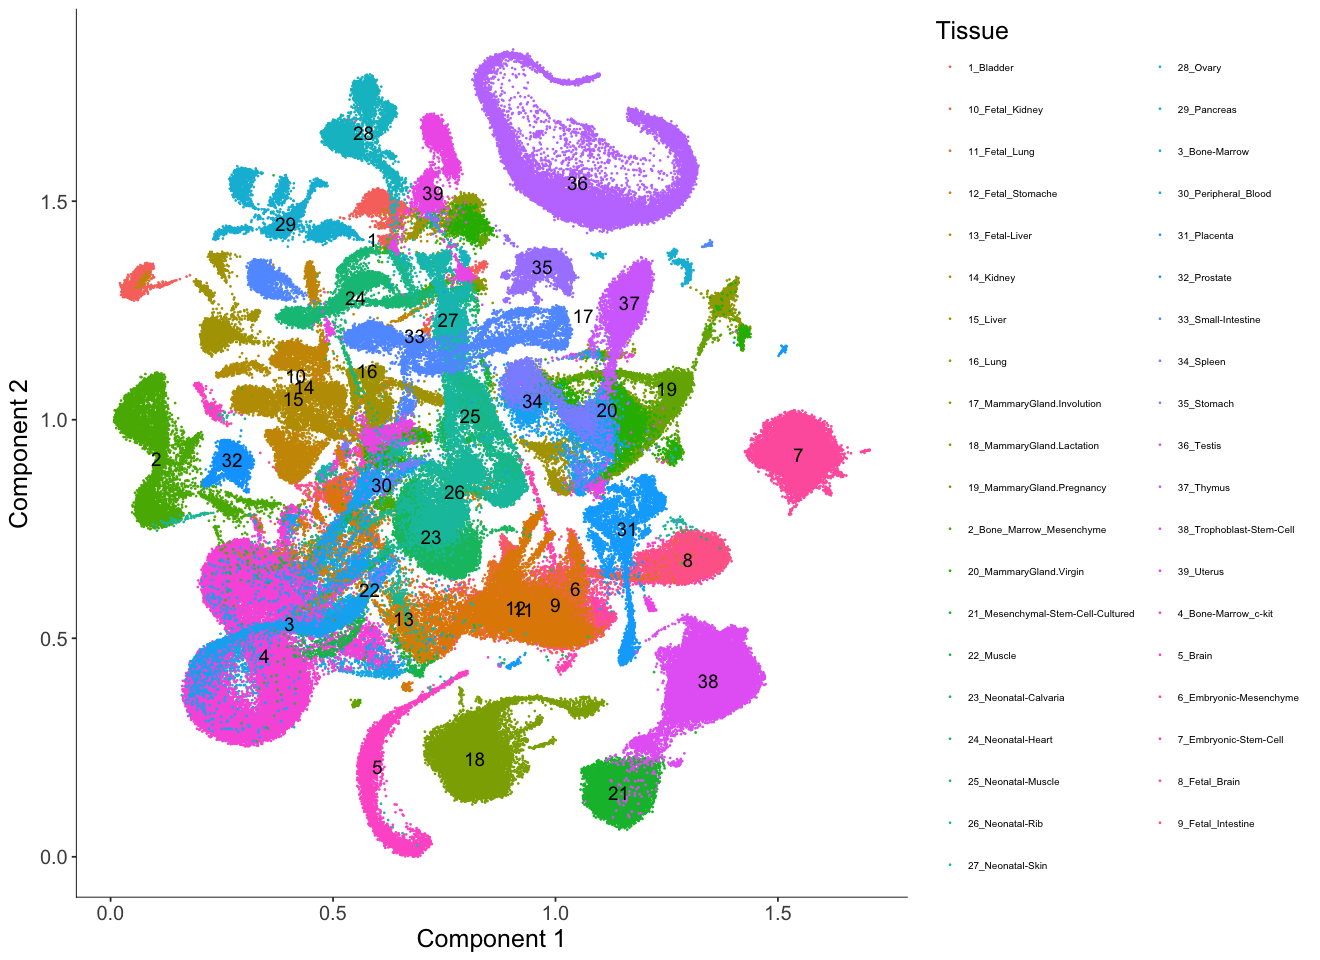

In [7]:
col_vector_origin <- c("#db83da",
                "#53c35d",
                "#a546bb",
                "#83b837",
                "#a469e6",
                "#babb3d",
                "#4f66dc",
                "#e68821",
                "#718fe8",
                "#d6ac3e",
                "#7957b4",
                "#468e36",
                "#d347ae",
                "#5dbf8c",
                "#e53e76",
                "#42c9b8",
                "#dd454a",
                "#3bbac6",
                "#d5542c",
                "#59aadc",
                "#cf8b36",
                "#4a61b0",
                "#8b8927",
                "#a24e99",
                "#9cb36a",
                "#ca3e87",
                "#36815b",
                "#b23c4e",
                "#5c702c",
                "#b79add",
                "#a55620",
                "#5076af",
                "#e38f67",
                "#85609c",
                "#caa569",
                "#9b466c",
                "#88692c",
                "#dd81a9",
                "#a35545",
                "#e08083",
                "#17becf",
                "#9edae5")
col_vector <- col_vector_origin[1:length(unique(as.character(pData(MCA_cds)$Tissue)))]
names(col_vector) <- unique(as.character(pData(MCA_cds)$Tissue))
options(repr.plot.width = 11)
options(repr.plot.height = 8)
plot_cell_clusters(MCA_cds, color_by = 'Tissue', cell_size = 0.1, show_group_id = T)  + 
theme(legend.text=element_text(size=6)) + #set the size of the text 
theme(legend.position="right") #put the color legend on the right

Here we first color the cells by the tissue type annotated from the original study. Setting `show_group_id = T` will plot the group ids according to `color_by`. If the corresponding group ids are string, we will assign each group a number and label the number on the embedding while attaching a number to the group ids from the color annotations. By doing so, we avoid overlaying strings on top of each other on the UMAP embedding. 

From the embedding, we can see that UMAP did a great job to separate cells from different tissue types and relevant cell types are clustered nearby one another. For example, fetal liver (13) and adult liver (15) are close to each other in the UMAP embedding. 

We can also color the cells by the cluster ID identified by the Louvain clustering algorithm. The cluster IDs are ordered from the largest cluster (in terms of number of cells) to the smallest cluster. Just by eye we can see that the clustering match well with tissue types from the original study. However, some clusters, (for example, clusters 1 and 5) appear to consist of multiple subclusters that haven't been broken up by the Louvain algorithm. We can either increase the `res` parameter when we run the clusterCells function to identify substructure or we can subset the cds and redo the Louvain clustering again on this subset to get more fine grained clusters. 

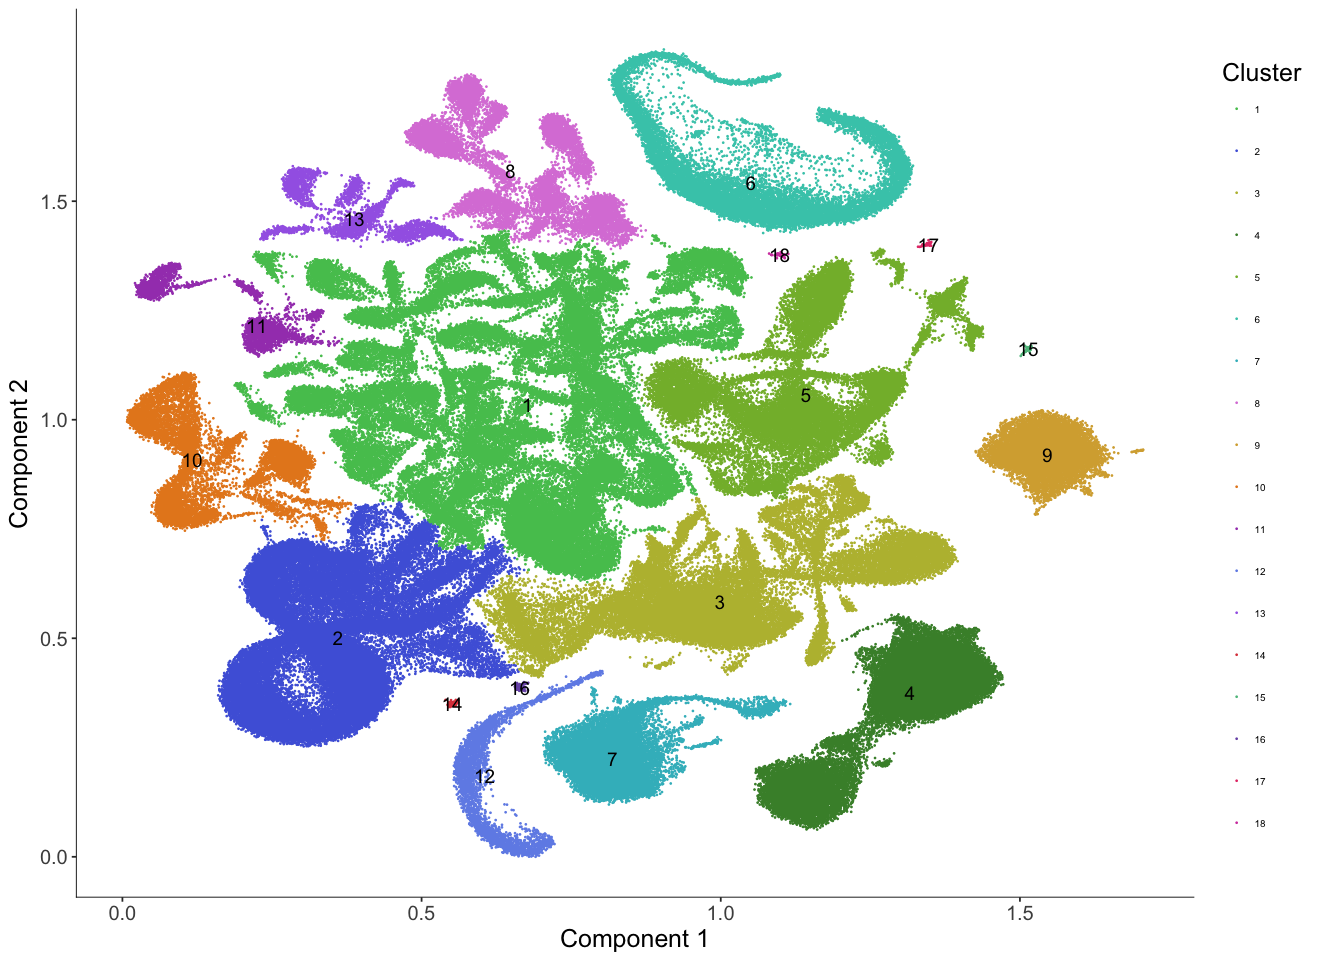

In [8]:
options(repr.plot.width = 11)
options(repr.plot.height = 8)
cluster_col_vector <- col_vector_origin[1:length(unique(as.character(pData(MCA_cds)$Cluster)))]
names(cluster_col_vector) <- unique(as.character(pData(MCA_cds)$Cluster))
plot_cell_clusters(MCA_cds, color_by = 'Cluster', cell_size = 0.1, show_group_id = T) + 
scale_color_manual(values = cluster_col_vector) + 
theme(legend.text=element_text(size=6)) + #set the size of the text 
theme(legend.position="right") #put the color legend on the right

## How do clusters break down by tissue?
We can check the percentage of cells in each cluster distributed into each tissue type. This can help us to figure out the identity of each cell cluster.

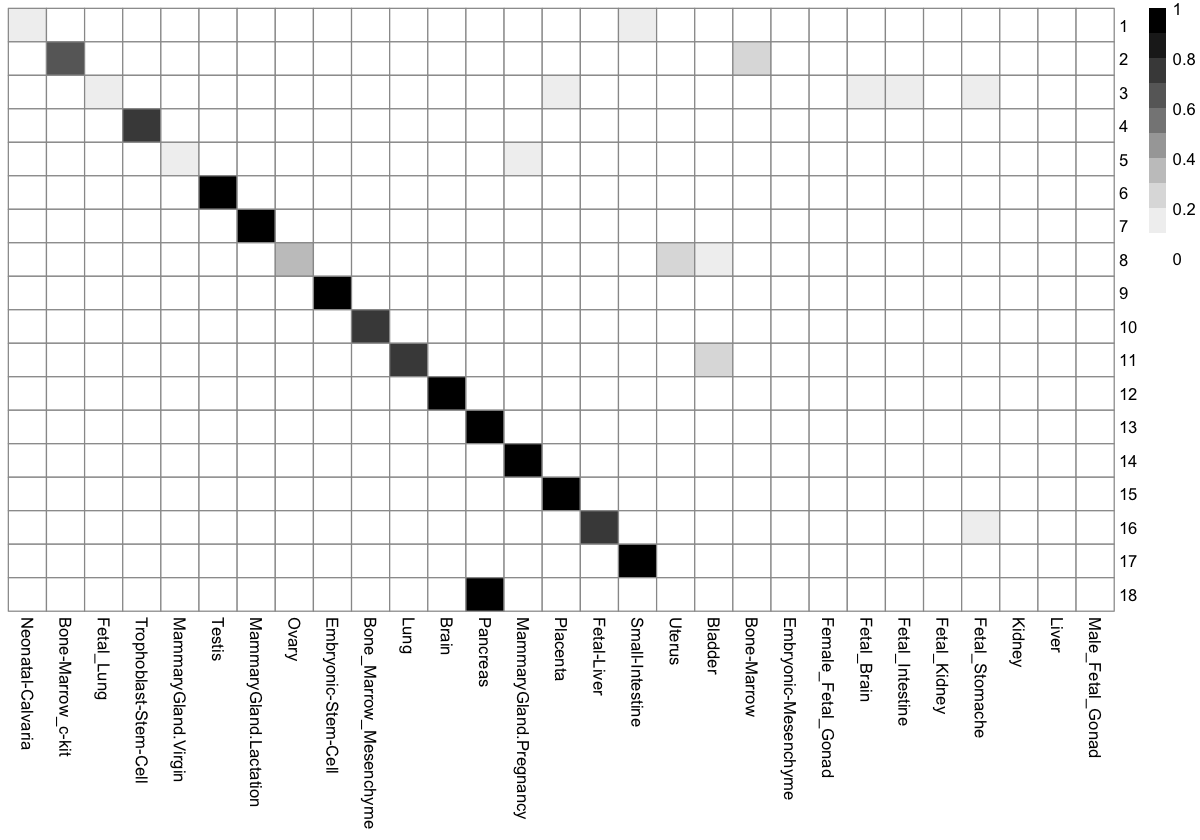

In [9]:
Cluster_tissue_stat <- table(pData(MCA_cds)[, c('Cluster', 'Tissue')])

Cluster_tissue_stat <- apply(Cluster_tissue_stat, 1, function(x) x / sum(x))

Cluster_tissue_stat_ordered <- t(Cluster_tissue_stat)

options(repr.plot.width=10, repr.plot.height=7)
    
order_mat <- t(apply(Cluster_tissue_stat_ordered, 1, order))
max_ind_vec <- c()
    
for(i in 1:nrow(order_mat)) {
  tmp <- max(which(!(order_mat[i, ] %in% max_ind_vec)))
  max_ind_vec <- c(max_ind_vec, order_mat[i, tmp])
}
    
max_ind_vec <- max_ind_vec[!is.na(max_ind_vec)]

max_ind_vec <- c(max_ind_vec, setdiff(1:ncol(Cluster_tissue_stat), max_ind_vec))
Cluster_tissue_stat_ordered <- Cluster_tissue_stat_ordered[, row.names(Cluster_tissue_stat)[max_ind_vec]]
                             
pheatmap::pheatmap(Cluster_tissue_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10)) # annotation_row = annotation_row, annotation_colors = annotation_colors

## How do tissues break down by cluster? 
We can also look at the distribution of tissue types across each cluster. This can help us to figure out how many  distinct cell types there are in each tissue.  

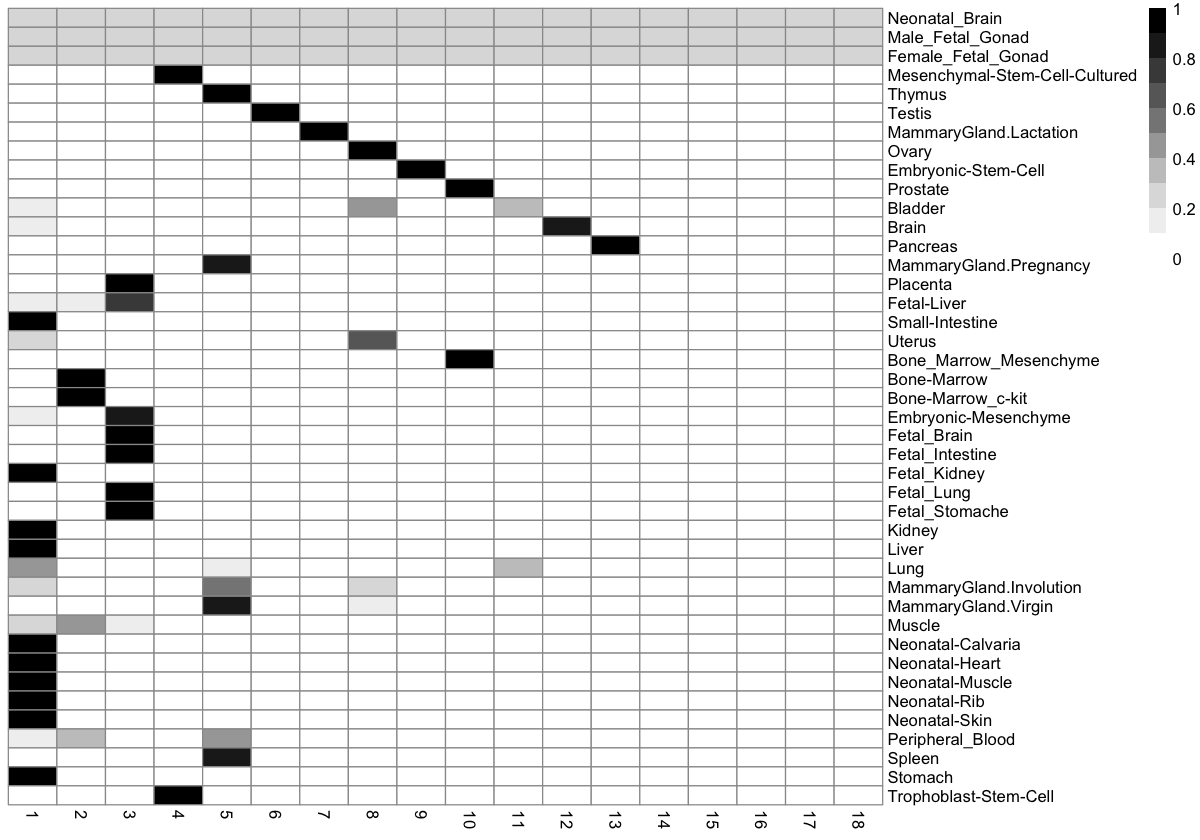

In [10]:
Cluster_tissue_stat <- table(pData(MCA_cds)[, c('Cluster', 'Tissue')])

Cluster_tissue_stat <- apply(Cluster_tissue_stat, 2, function(x) x / sum(x))

Cluster_tissue_stat_ordered <- t(Cluster_tissue_stat)

options(repr.plot.width=10, repr.plot.height=7)
order_mat <- t(apply(Cluster_tissue_stat_ordered, 2, order))
max_ind_vec <- c()
    
for(i in 1:nrow(order_mat)) {
  tmp <- max(which(!(order_mat[i, ] %in% max_ind_vec)))
  max_ind_vec <- c(max_ind_vec, order_mat[i, tmp])
}

max_ind_vec <- max_ind_vec[!is.na(max_ind_vec)]

max_ind_vec <- c(max_ind_vec, setdiff(1:ncol(Cluster_tissue_stat), max_ind_vec))
Cluster_tissue_stat_ordered <- Cluster_tissue_stat_ordered[colnames(Cluster_tissue_stat)[max_ind_vec], ]
                             
pheatmap::pheatmap(Cluster_tissue_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10)) # annotation_row = annotation_row, annotation_colors = annotation_colors

# How to choose the resolution for louvain clustering
Clustering is more or less like an art. The "right" resolution for clustering depends on your data and on your need during downstream analysis. Here we demonstrate the resolution parameters from the louvain clustering algorithm can help us to show the granularity of cell clustering structure. The above resolution with 1e-6 works quite well but we will use 2 other different resolutions (5e-5 and 5e-7) to show this effect. 

Run kNN based graph clustering starts:
  -Input data of 242533 rows and 2 columns
  -k is set to 20


  Finding nearest neighbors...DONE ~ 1.078 s
  Compute jaccard coefficient between nearest-neighbor sets ...DONE ~ 0.097 s
  Build undirected graph from the weighted links ...DONE ~ 1.561 s
  Run louvain clustering on the graph ...
Running louvain iteration  1 ...


Current iteration is 1; current resolution is 5e-05; Modularity is 0.966697632538796; Number of clusters are 60
Maximal modularity is 0.966697632538796; corresponding resolution is 5e-05

Run kNN based graph clustering DONE, totally takes 36.2788619995117 s.


  -Number of clusters: 60 


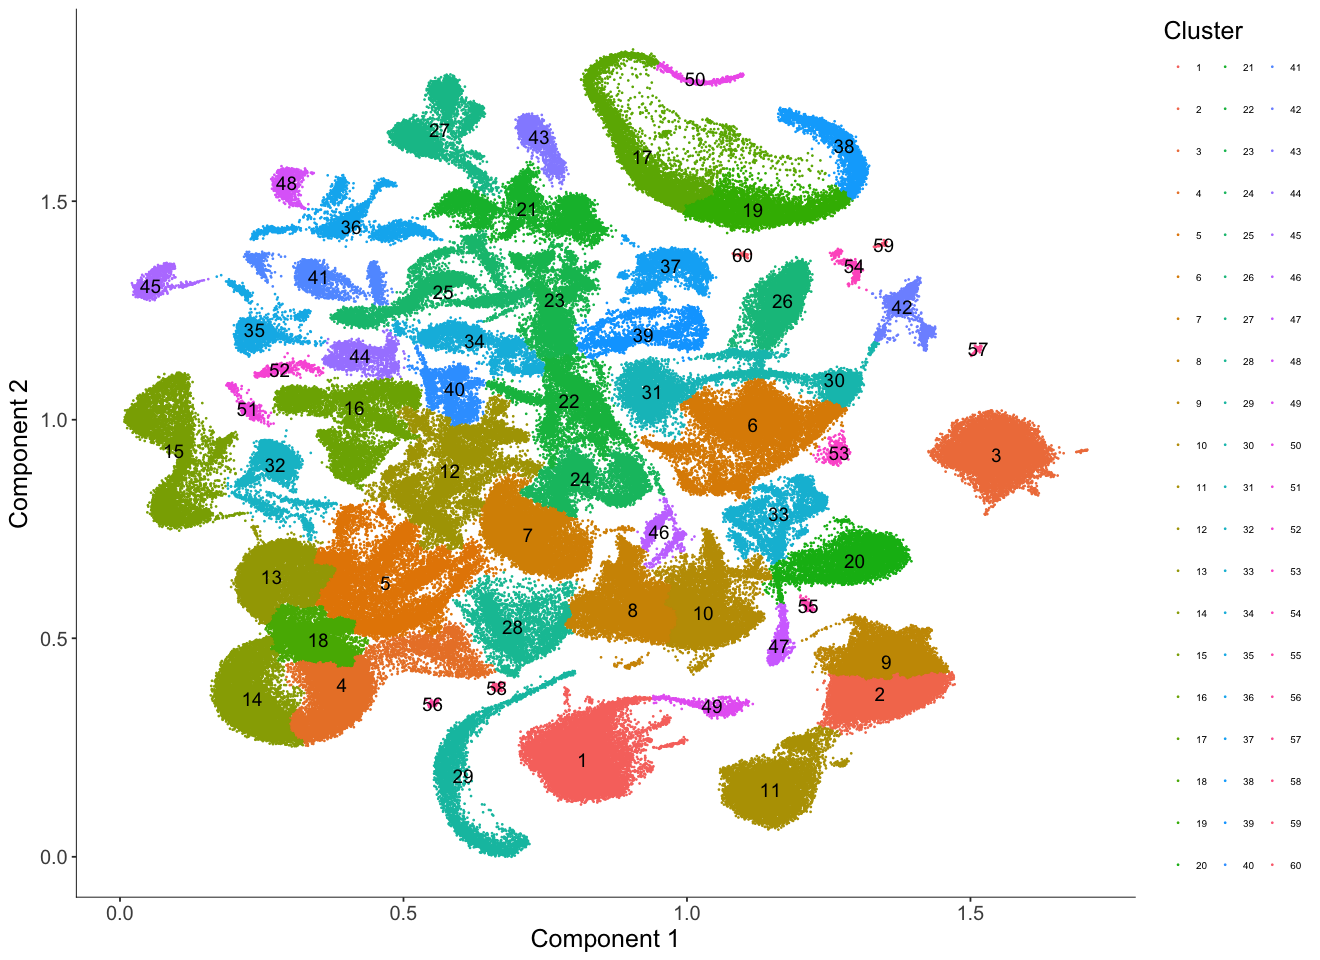

In [11]:
options(repr.plot.width = 11)
options(repr.plot.height = 8)
MCA_cds_res_resolution <- clusterCells(MCA_cds, use_pca = F, method = 'louvain', res = 5e-5, louvain_iter = 1, verbose = T)
cluster_col_vector <- col_vector_origin[1:length(unique(as.character(pData(MCA_cds_res_resolution)$Cluster)))]
names(cluster_col_vector) <- unique(as.character(pData(MCA_cds_res_resolution)$Cluster))

plot_cell_clusters(MCA_cds_res_resolution, color_by = 'Cluster', cell_size = 0.1, show_group_id = T) + 
theme(legend.text=element_text(size=6)) + #set the size of the text 
theme(legend.position="right") #put the color legend on the right

We can see cluster 1 in the previous case with resolution 1e-6 is now separated into four clusters (2, 4, 17, 19). Similarly, cluster 3 is now separated into three clusters 19, 11, 14. 

Run kNN based graph clustering starts:
  -Input data of 242533 rows and 2 columns
  -k is set to 20


  Finding nearest neighbors...DONE ~ 1.001 s
  Compute jaccard coefficient between nearest-neighbor sets ...DONE ~ 0.098 s
  Build undirected graph from the weighted links ...DONE ~ 1.548 s
  Run louvain clustering on the graph ...
Running louvain iteration  1 ...


Current iteration is 1; current resolution is 5e-07; Modularity is 0.830815906657048; Number of clusters are 15
Maximal modularity is 0.830815906657048; corresponding resolution is 5e-07

Run kNN based graph clustering DONE, totally takes 34.8044009208679 s.


  -Number of clusters: 15 


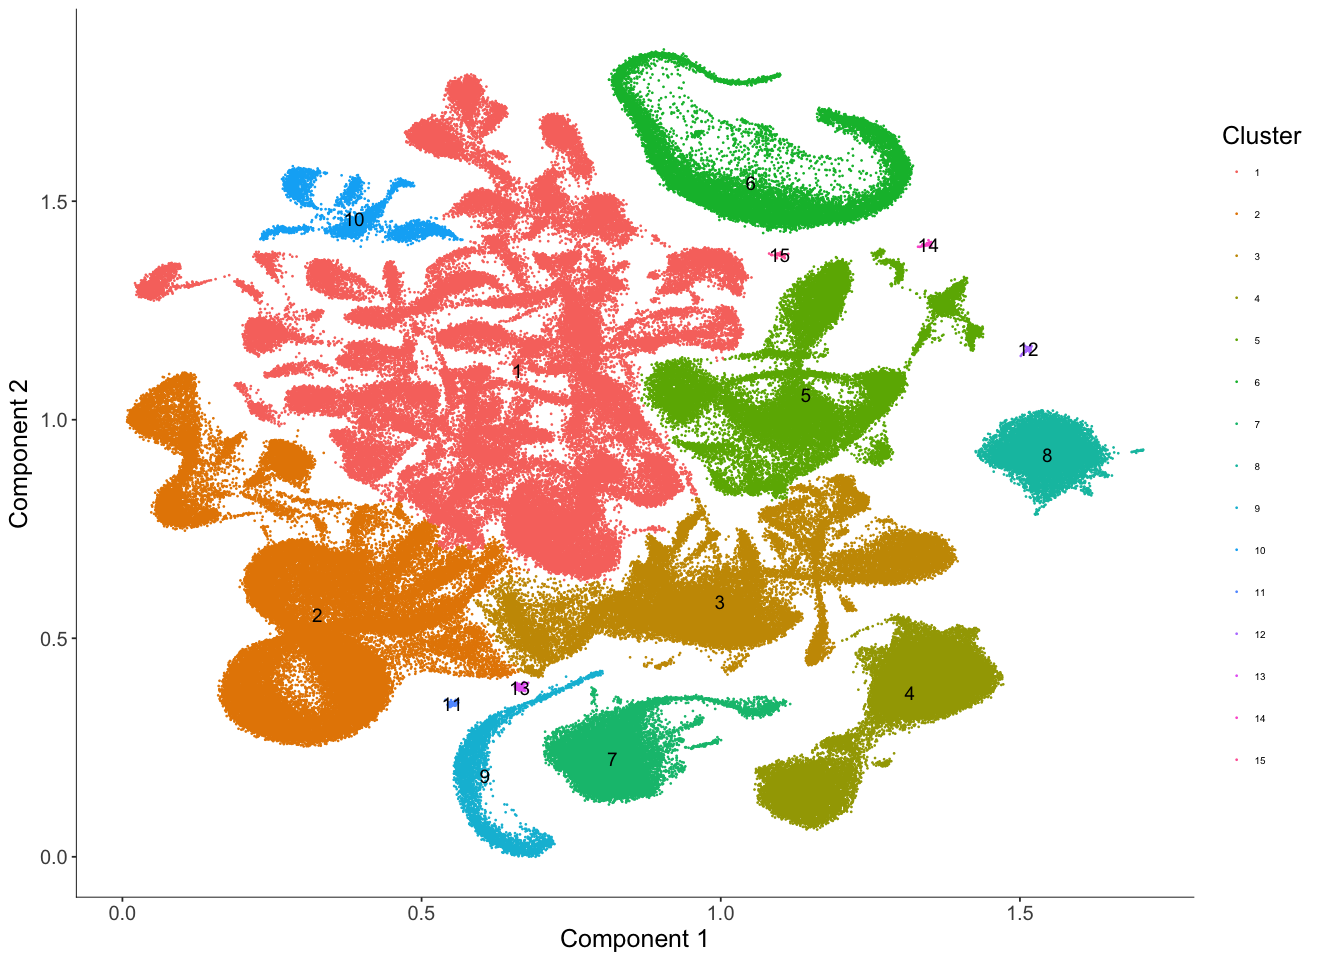

In [12]:
options(repr.plot.width = 11)
options(repr.plot.height = 8)
MCA_cds_res_resolution <- clusterCells(MCA_cds, use_pca = F, method = 'louvain', res = 5e-7, louvain_iter = 1, verbose = T)
cluster_col_vector <- col_vector_origin[1:length(unique(as.character(pData(MCA_cds_res_resolution)$Cluster)))]
names(cluster_col_vector) <- unique(as.character(pData(MCA_cds_res_resolution)$Cluster))

plot_cell_clusters(MCA_cds_res_resolution, color_by = 'Cluster', cell_size = 0.1, show_group_id = T) + 
theme(legend.text=element_text(size=6)) + #set the size of the text 
theme(legend.position="right") #put the color legend on the right

# Identify genes that are differentially expressed between clusters

** Include link here to the relevant section of the other tutorial ** 

As mentioned in the previous tutorial, we introduced a powerful statistical test to identify genes that vary along a trajectory. The test, which uses a variant of Moran's I works by finding genes that vary over a graph that describes the topological relationships between the cells. This test (implemented in the `principalGraphTest` function) is very general and can be also applied to identify genes that are differentially expressed between clusters. Note that since we haven't learned a developmental trajectory for this CellDataSet Monocle 3 will the k-nearest-neighbor graph constructed by  UMAP as the graph for the Moran's I test. There are quite a few cells in the dataset, so this test can take a few hours. The running time of this test depends on the `k` parameter to `principalGraphTest`. Like other differential expression function in Monocle, `principalGraphTest` can use multiple cores, so you may want to run this on a multi-core machine.

In [13]:
start <- Sys.time()
spatial_res <- principalGraphTest(MCA_cds, relative_expr = TRUE, k = 25, cores = detectCores() - 2, verbose = FALSE)
end <- Sys.time()
end - start

Time difference of 3.55259 hours

# Finding cluster-specific marker genes

Often, we wish to find genes that are not only differentially expressed across clusters - we want genes that are expressed only in certain clusters. There are many ways of doing this, but many statistically principled methods are also quite slow, espcially on large datasets. Monocle 3's test for finding genes that vary between clusters, in contrast is both fast and can easily be post-processed to yield genes *specific* to each cluster.

To categorize genes into cluster specific genes, we simply calculate the *specificity* of each gene to each cell cluster. In Monocle 3, we introduce the `find_cluster_markers` function to find marker genes for each group of cells. This function measures specificity using the *Jensen-Shannon distance*, which is often used to identify highly tissue specific genes (Cabili et al, Genome Research). Genes that have scores close to one for a cluster are highly specific to that cluster. 

In [14]:
cluster_marker_res <- find_cluster_markers(MCA_cds, spatial_res, group_by = 'Cluster', morans_I_threshold = 0.25)

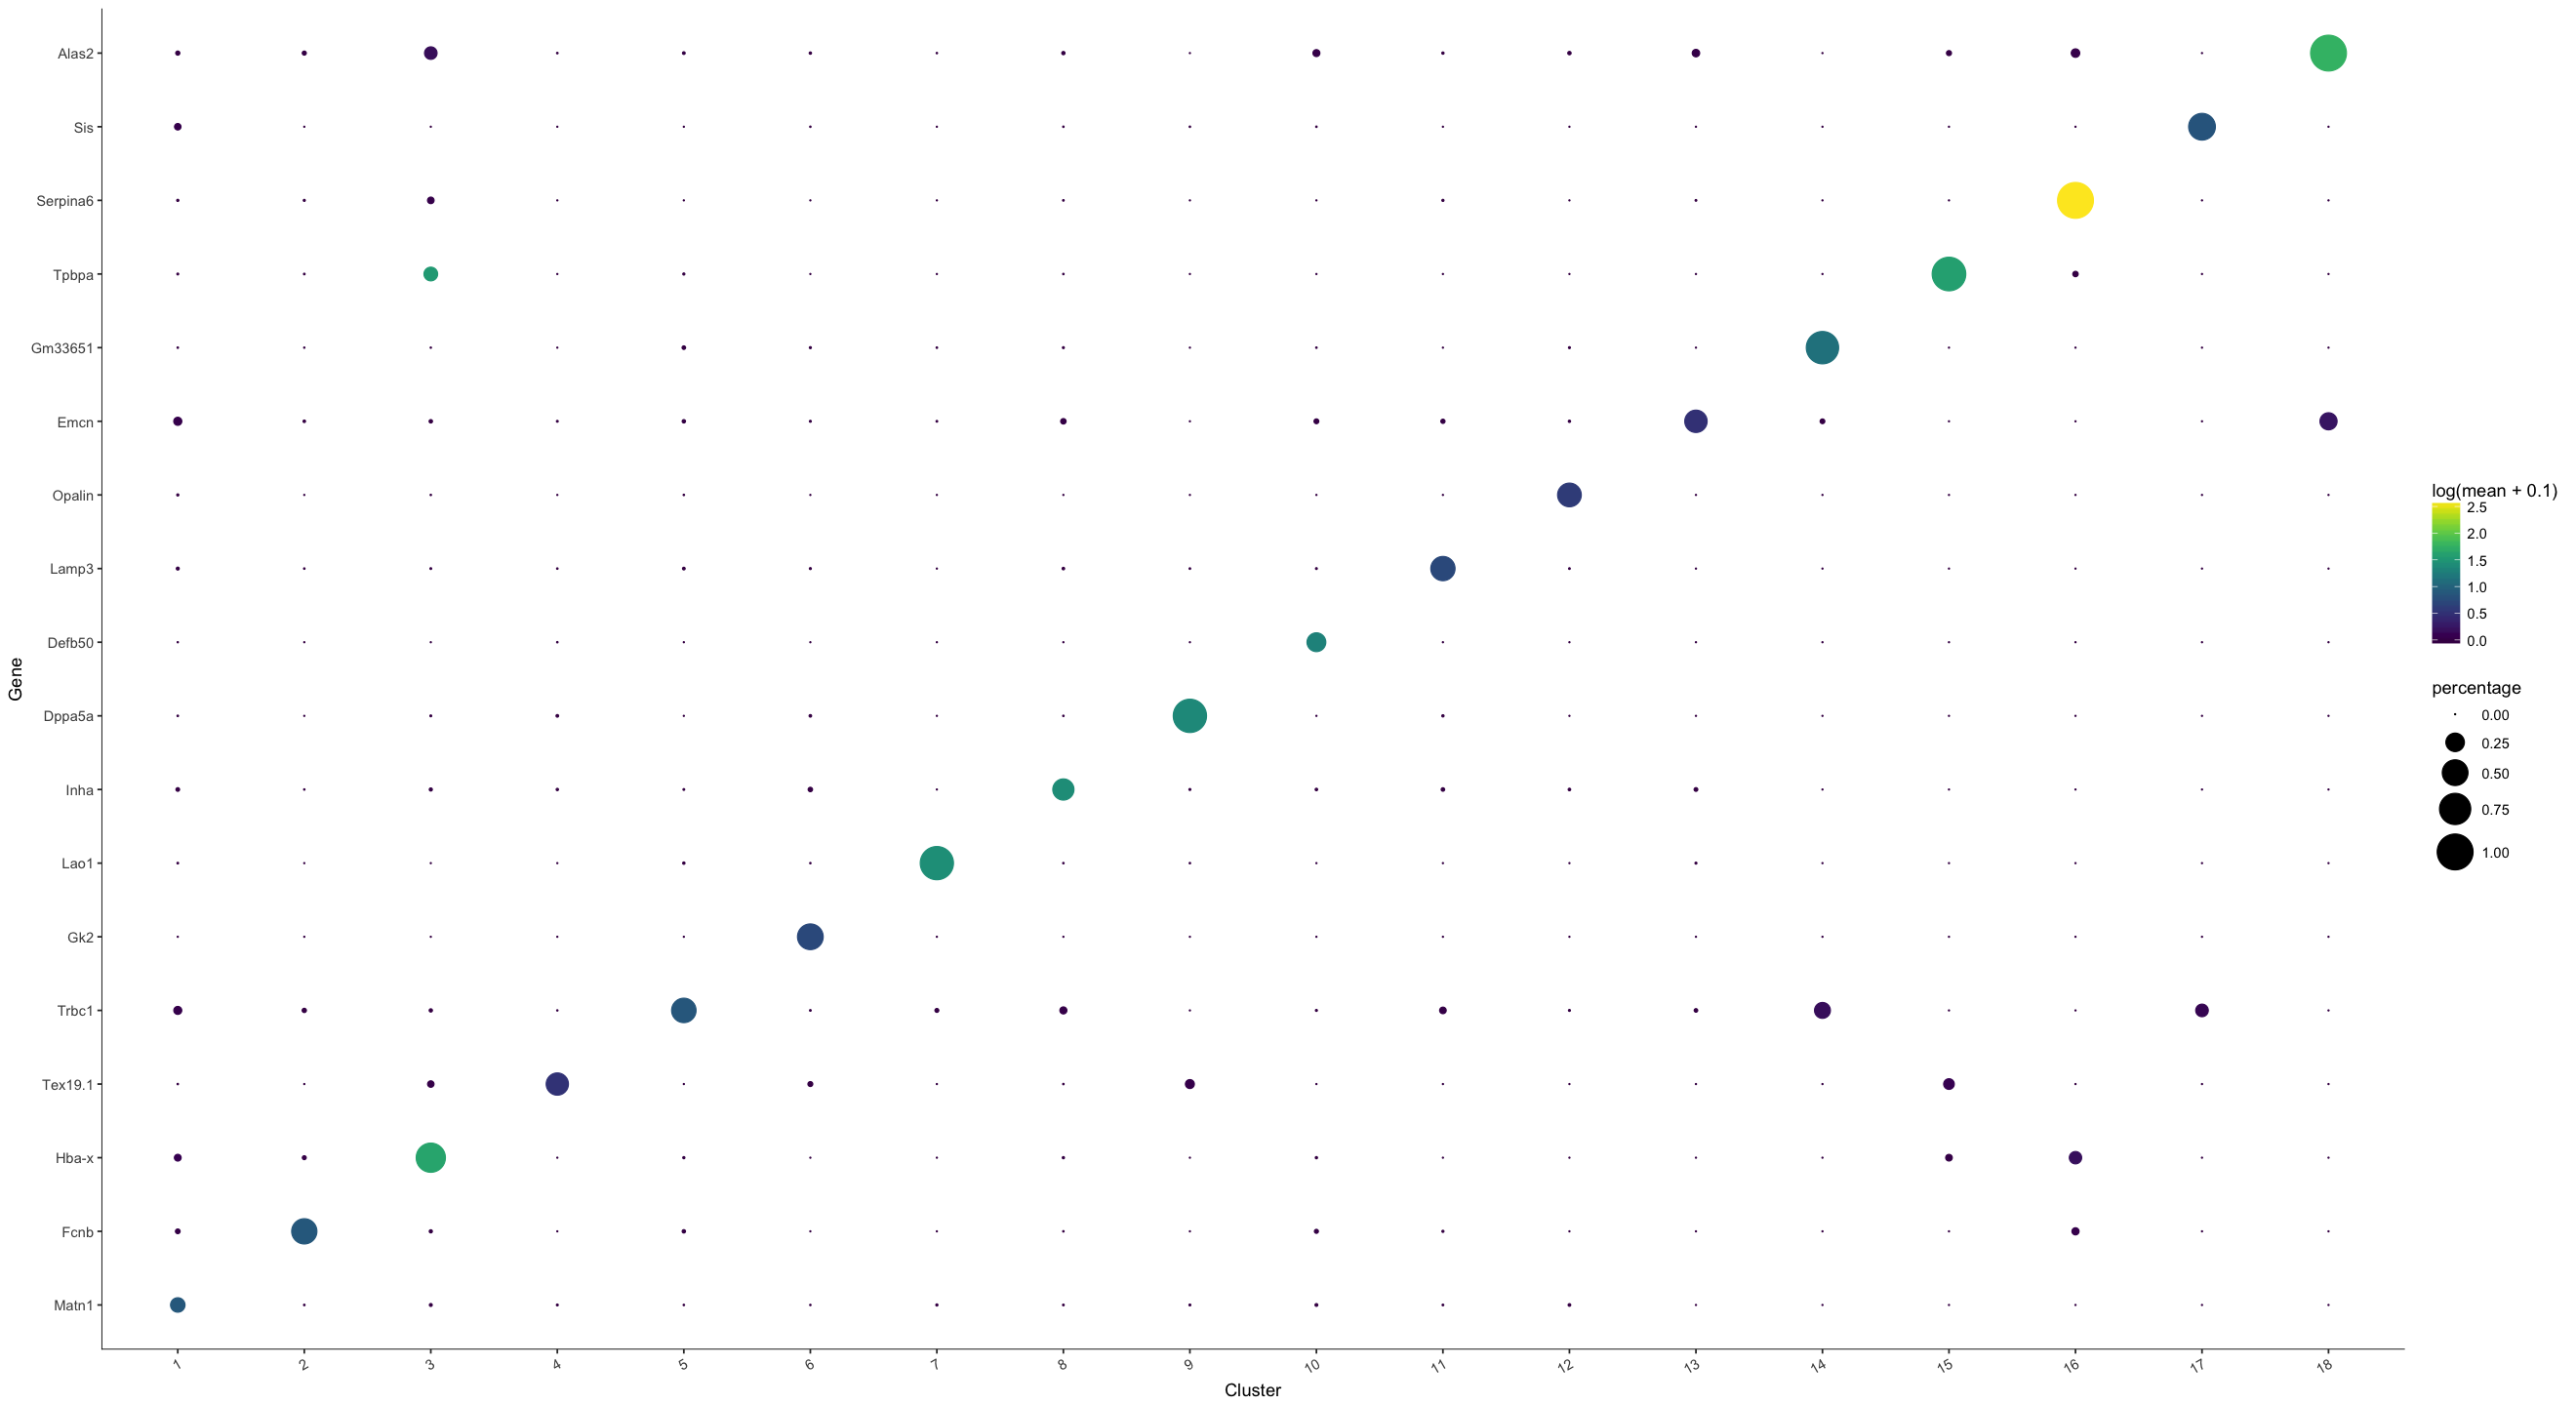

In [15]:
genes <- (cluster_marker_res %>% dplyr::filter(mean > 0.5, percentage > 0.1) %>% dplyr::group_by(Group) %>% dplyr::slice(which.max(specificity)))
options(repr.plot.width=22, repr.plot.height=12)
plot_markers_by_group(MCA_cds, genes$gene_short_name, group_by = 'Cluster', ordering_type = 'maximal_on_diag')

# Visualizing marker expression across cell clusters 
It is often very useful to visualize the marker gene expression pattern across cell clusters to associate each cluster with particular cell types based on the markers. In Monocle 3, we provide the `plot_markers_cluster` function to visualize a heatmap of markers across cell clusters. 
We first select top 5 significant genes of the entire set of significant gene based on the principal graph test from each cluster based on the specifity score. Then we feed those genes into the plot_markers_cluster function. As the single cell RNA-seq datasets get bigger, we cannot visualize all cells. This argument helps the users to visualize large scale dataset with an uniform downsampling scheme for cells. By default, if the cell number is larger than 50000, we downsample to 1000 cells. We can also ignore small clusters that is hard to visualize on the heatmap with a minimum fraction of cell number for a cluster to the largest cluster. 

From the figure below, we see that the identified markers genes indeed show strong cluster specificity. We can also see that marker genes for cluster 3 is not very strong, probably reflecting the fact that cluster 3 seems like including a mixture of different types of cells from the UMAP embedding. Similarly, we can also see that cluster 7 seems like contain two groups of genes showing strong specifity. Let us take a look for some genes for cluster 7 (and then for cluster 8).

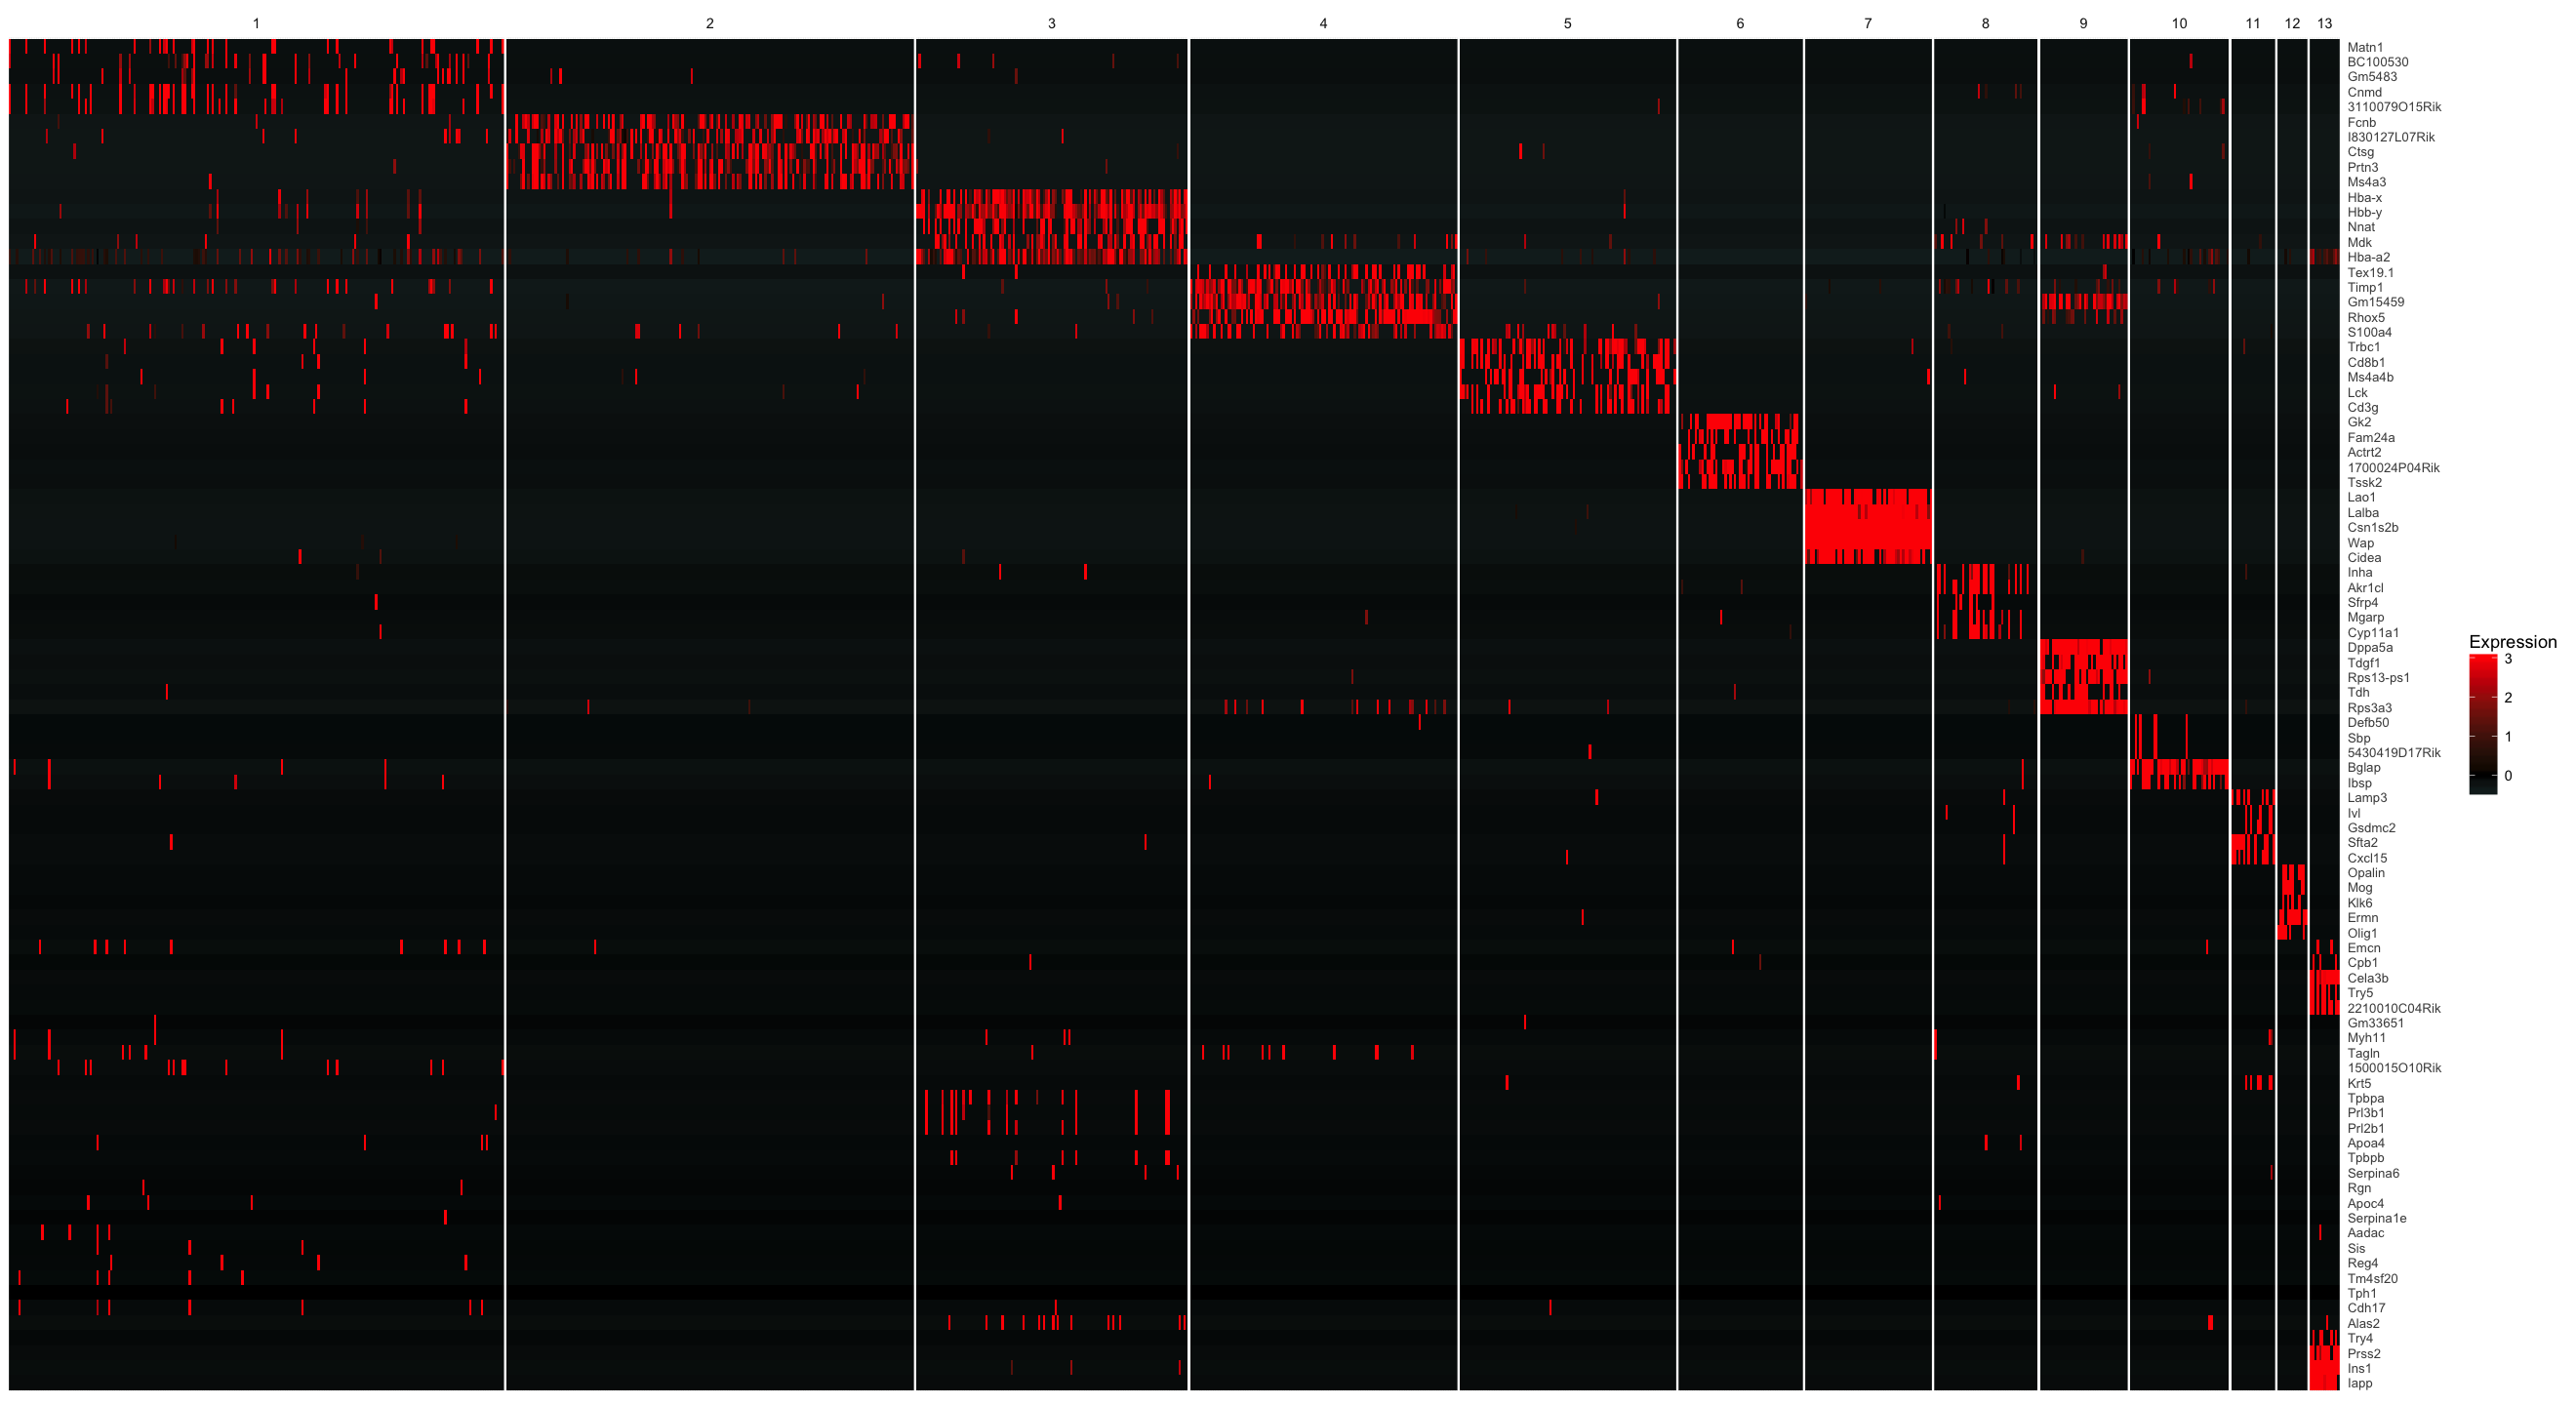

In [17]:
genes <- (cluster_marker_res %>% dplyr::filter(mean > 0.5, percentage > 0.1) %>% dplyr::group_by(Group) %>% dplyr::top_n(5, wt = specificity))
plot_markers_cluster(MCA_cds, as.character(genes$gene_short_name), minimal_cluster_fraction = 0.05)

We can also select genes in each group based on a specifity score. By doing this, we are able to see the difference in terms of number of genes across each cell cluster more clearly. Here we filter genes with specifity large than 0.7 and then group the genes by clusters, followed by sorting the specifity score in each cell cluster. 

From the figure below, we can see that cluster 7 has a large number of cluster specific genes. From the plot with cell clusters on the umap embedding, we know that cluster 7 are testis genes. Testis are notoriously known for expressing lots of genes that are normally restricted to other cell types. On the other hand, many highly specific genes are expressed in their tissue of origin and but at low levels of testis. So this result makes perfect sense biologically. 

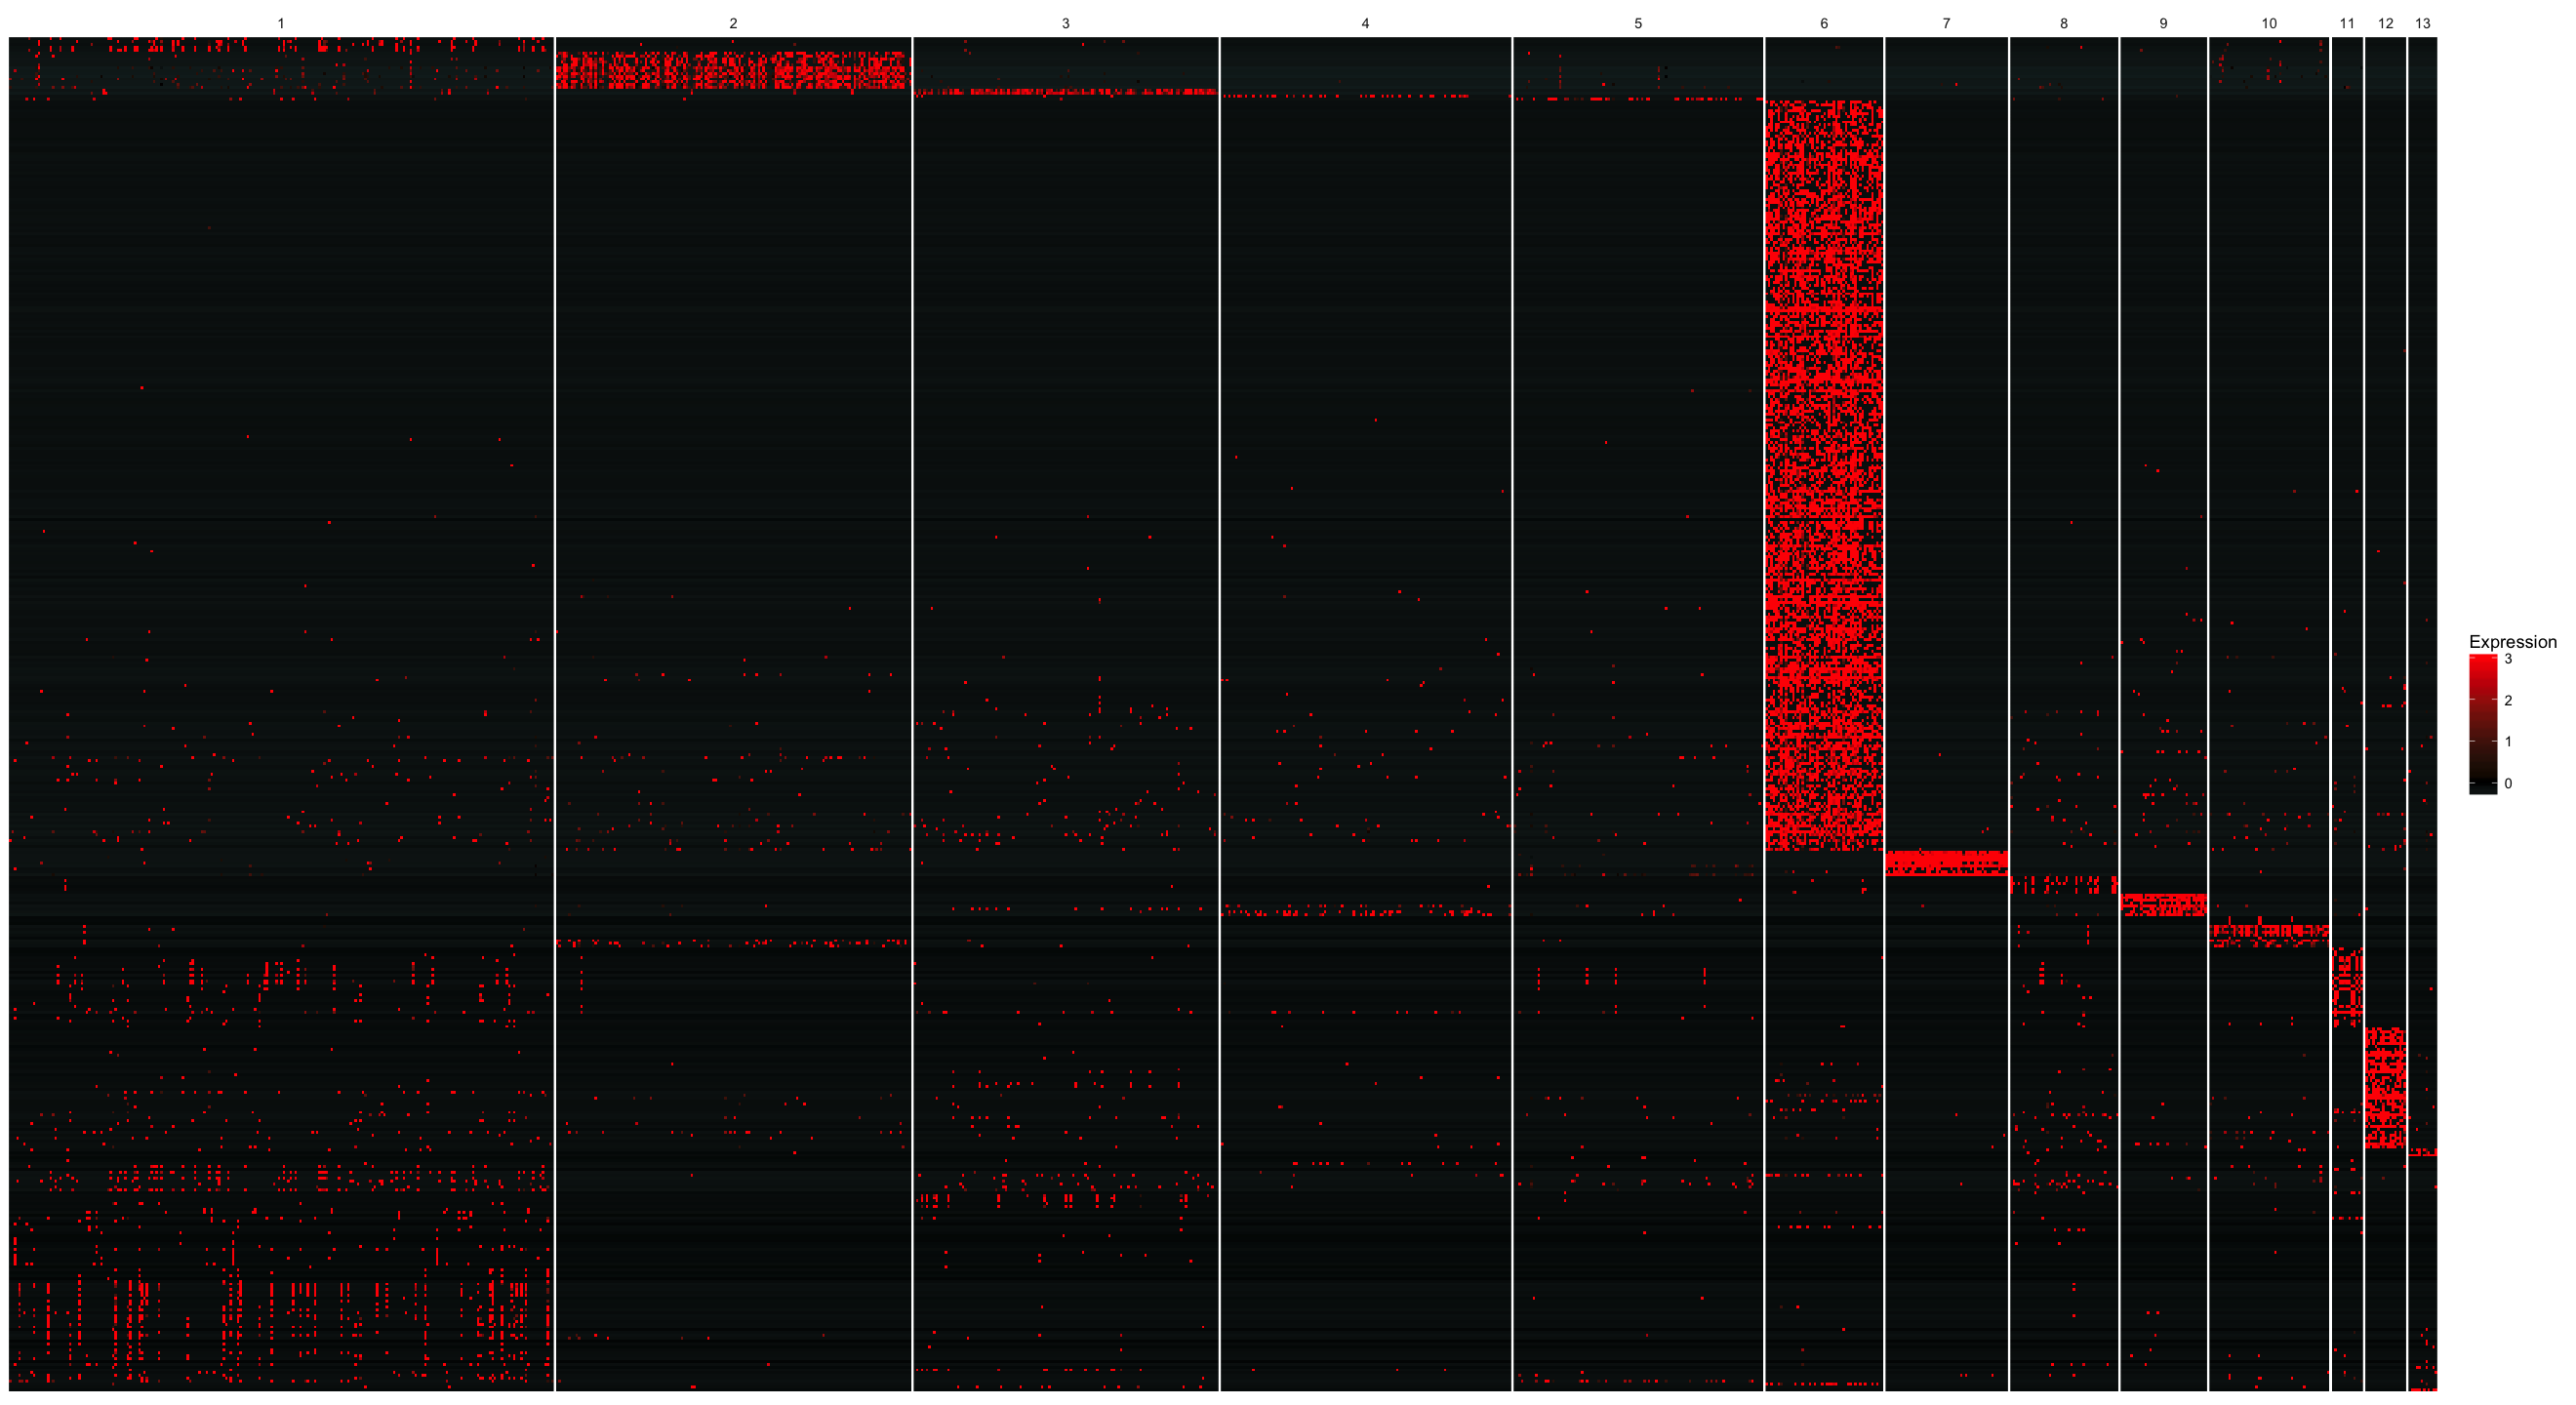

In [18]:
options(repr.plot.width=22, repr.plot.height=12)
genes <- cluster_marker_res %>% dplyr::filter(mean > 0.5, percentage > 0.1, specificity > 0.7) %>% dplyr::group_by(Group) %>% dplyr::arrange(Group, dplyr::desc(specificity))
plot_markers_cluster(MCA_cds, as.character(genes$gene_short_name), minimal_cluster_fraction = 0.05, show_rownames = F)

# Visualizing marker expression in UMAP plots

Sometimes it's important to show the expression level for a set of genes in UMAP or t-SNE plots. Let's select a few highly specific genes:

In [19]:
top_4_genes <- genes %>% dplyr::filter(Group == 7) %>% dplyr::top_n(n = 4, wt  = specificity)
top_4_genes

Group Gene    gene_short_name specificity morans_I  morans_test_statistic
1 7     Lao1    Lao1            0.9795237   0.8505168 1532.571             
2 7     Lalba   Lalba           0.9502404   0.9662100 1741.026             
3 7     Csn1s2b Csn1s2b         0.9422779   0.9950623 1793.012             
4 7     Wap     Wap             0.9350323   0.9932139 1789.681             
  pval qval mean     num_cells_expressed_in_group percentage status
1 0    0    1.422162 11564                        0.8544407  OK    
2 0    0    2.240092 13324                        0.9844835  OK    
3 0    0    4.832813 13534                        1.0000000  OK    
4 0    0    5.215716 13534                        1.0000000  OK    
  use_for_ordering
1 TRUE            
2 TRUE            
3 TRUE            
4 TRUE

Now we can use `plot_cell_clusters` with the `markers` argument to render these genes' expression levels.

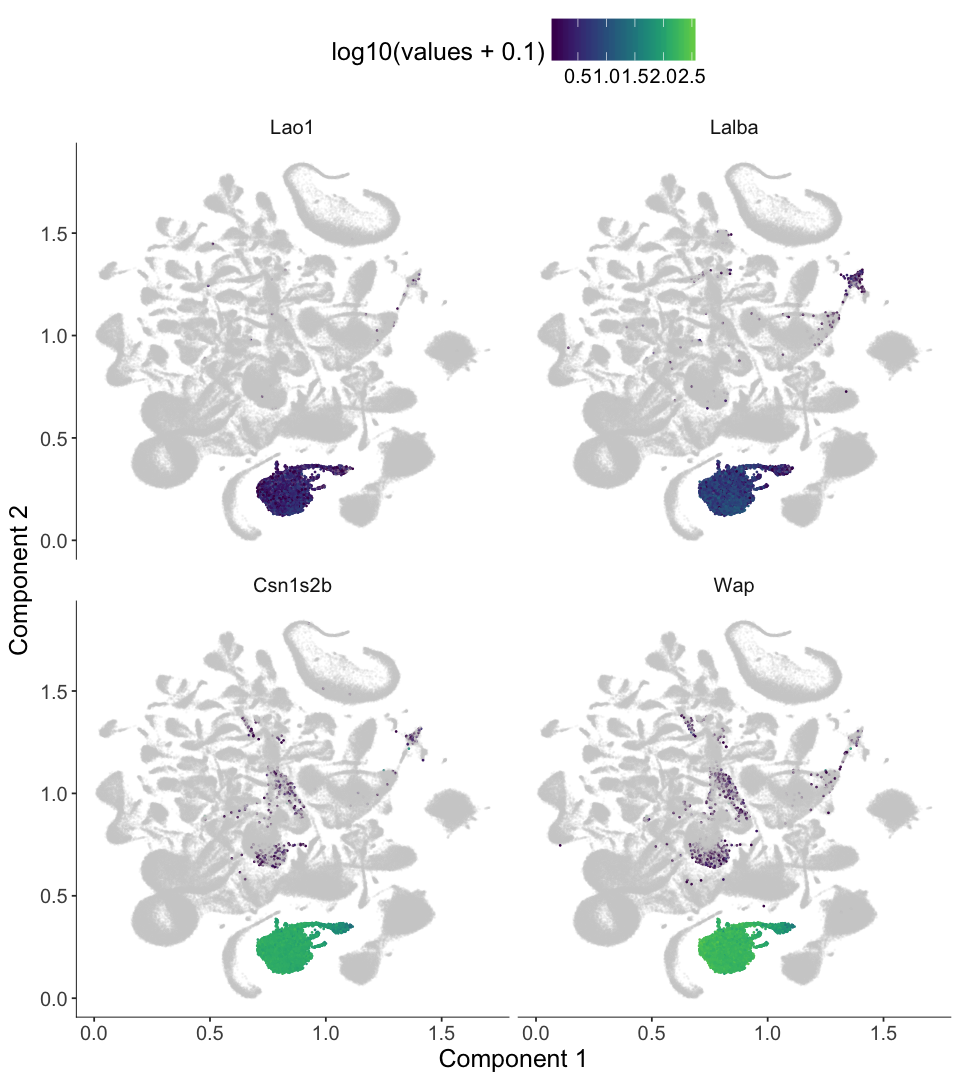

In [20]:
options(repr.plot.width = 8)
options(repr.plot.height = 9)
marker_genes <- top_4_genes$Gene
plot_cell_clusters(MCA_cds, markers = as.character(marker_genes), show_group_id = T, cell_size = 0.1)

Group Gene   gene_short_name specificity morans_I  morans_test_statistic pval
1 7     Csn1s1 Csn1s1          0.7045754   0.9758849 1758.448              0   
2 7     Csn3   Csn3            0.6974297   0.9701249 1748.067              0   
  qval mean     num_cells_expressed_in_group percentage status use_for_ordering
1 0    4.675093 13534                        1          OK     TRUE            
2 0    4.665920 13534                        1          OK     TRUE

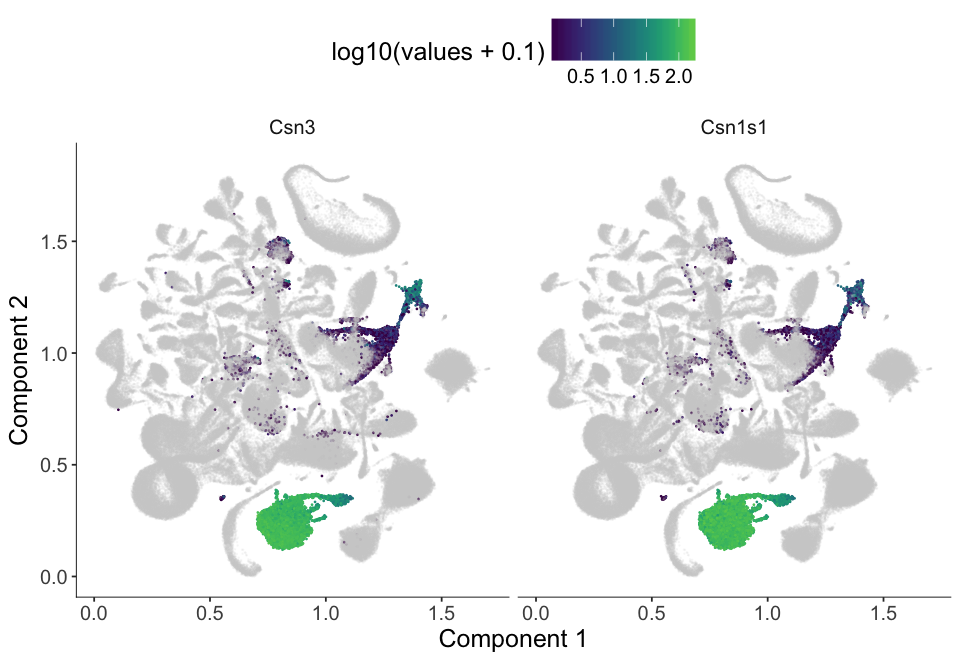

In [21]:
cluster_marker_res %>% dplyr::filter(gene_short_name %in% c('Csn3', 'Csn1s1'), Group == 7)
options(repr.plot.width = 8)
options(repr.plot.height = 5.5)
plot_cell_clusters(MCA_cds, markers = c('Csn3', 'Csn1s1'), show_group_id = T, cell_size = 0.1)

We see that genes from the second group of genes doesn't seem to be specific to cluster 7 as the `cluster_marker_res` table shows that this gene has only about 0.45 specificity. From the umap embedding, we see it is actually specific to cluster 8 and also expressed in cluster 10. 

# Show sessionInfo

In [22]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] grid      splines   parallel  stats4    stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2        dplyr_0.7.6           mcclust_1.0          
 [4] lpSolve_5.6.13        flexclust_1.3-5       modeltools_0.2-21    
 [7] lattice_0.20-35       monocle_2.99.0        L1Graph_0.1.0        
[10] lpSolveAPI_5.5.2.0-17 igraph_1.2.1          DDRTree_0.1.5        
[13] irlba_2.3.2           VGAM_1.0-5            ggplot2_2.2.1        
[16] Biobase_2.40.0        DelayedArray_0.6.1    BiocParallel_1.14.1  
[19] IRanges_2.14.10 

# Save data for future usage

In [23]:
save.image('/Users/andyshehmohajeri/Downloads/MCA_monocle3.RData')

In [24]:
saveRDS(spatial_res, "/Users/andyshehmohajeri/Downloads/spatial_res.rds")
saveRDS(MCA_cds, "/Users/andyshehmohajeri/Downloads/MCA_cds.rds")

# Visualize the UMAP embedding in 3 dimensions 
In Monocle 3, we provide the `plot_3d_cell_trajectory` function to plot a dataset in 3 dimensions. By default, this method is used to visualize the trajectory and low dimensional space after running `learnGraph`. However, it can be also used to visualize the result from `UMAP` where the trajectory corresponds to the fuzzy simplicial set (or fuzzy graph) learnt from umap. 

In [25]:
# trajectory_i_dir <- "/Users/xqiu/Dropbox (Personal)/Projects/Monocle3/Result/"
# plot_3d_cell_trajectory(MCA_cds, 
#                         color_by="Tissue", 
#                         webGL_filename=paste(trajectory_i_dir, "MCA_cds.html", sep=""), 
#                         palette=col_vector,
#                         show_backbone=TRUE, 
#                         useNULL_GLdev=TRUE)

# Other analysis or visualization
In another tutorial for the Mouse Cell Atlas (MCA) dataset analysis, we showed analysis to identify spatially correlated genes in the low dimensional embedding. In addition, we also showed how to visualize the developmental trajectory as well as the significantl spatially correlated gene expression patterns in three dimensions. 
Since the workflow will be the same as that in MCA dataset analysis, in the following we will only provide a concise introduction of those analysis and visualizations. 